In [1]:
import os
from astropy.io import fits
import cfis

plt.ioff()

In [2]:
# Download spectroscopic data:
# - 3DHST (AEGIS and GOODS-N)
#   http://monoceros.astro.yale.edu/RELEASE_V4.1.5/3dhst.v4.1.5.master.fits.gz
#   (Need to first register at https://3dhst.research.yale.edu/signup.php)
# - DEEP2, DEEP3:
#   deep.ps.uci.edu/deep3/zcat_archive/alldeep.egs.uniq.2012jun13.fits.gz

# Download directory
cat_home = '{}/astro/data/CFIS/spectro_surveys'.format(os.environ['HOME'])

In [3]:
class Survey(object):
    
    def __init__(self, path, name, key_ra, key_dec, color, dec_min=30, dec_max=90):
        self.path = path
        self.name = name
        self.key_ra = key_ra
        self.key_dec = key_dec
        self.color = color
        
        self.set_coords(dec_min, dec_max)
        
    def set_coords(self, dec_min, dec_max):
        """Return coordinates within UNIONS footprint
        """
  
        dat = fits.open(self.path)
        ra = dat[1].data[self.key_ra]
        dec = dat[1].data[self.key_dec]
        
        # Cut area
        idx1 = (dec_min < dec)
        idx2 = (dec < dec_max)
        idx = idx1 & idx2
        
        n_tot = len(dec)
        n_UNIONS = len(dec[idx])
        print('{}: {} objects in total, {}/{} = {:.1f}% in UNIONS footprint'
              ''.format(self.name, n_tot, n_UNIONS, n_tot, n_UNIONS/n_tot*100))
        
        self._ra = ra[idx]
        self._dec = dec[idx]
        
        self._min_ra = min(self._ra)
        self._max_ra = max(self._ra)
        self._min_dec = min(self._dec)
        self._max_dec = max(self._dec)


In [14]:
# Spectroscopic survey data
survey = []

survey.append(Survey('{}/3dhst.v4.1.5.master.fits'.format(cat_home), 
                     '3DHST-AEGIS', 'ra', 'dec', 'green', dec_max=60))

# Goods-North has not yet overlap with UNIONS
#survey.append(Survey('{}/3dhst.v4.1.5.master.fits'.format(cat_home), 
#                     '3DHST-GOODS-N', 'ra', 'dec', 'blue', dec_min=60))

survey.append(Survey('{}/alldeep.egs.uniq.2012jun13.fits'.format(cat_home),
                     'DEEP2+3', 'RA', 'dec', 'magenta'))

3DHST-AEGIS: 207967 objects in total, 41200/207967 = 19.8% in UNIONS footprint
DEEP2+3: 23822 objects in total, 23822/23822 = 100.0% in UNIONS footprint


In [17]:
# CFIS data set-up
unit = 'deg'
band = 'r'
image_type = 'tile'
d = 0.5
sp_home = '{}/astro/repositories/github/shapepipe'.format(os.environ['HOME'])
tiles_ID = '{}/aux/CFIS/tiles_202007/tiles_all_order.txt'.format(sp_home)

# Get list of all images
images = cfis.get_image_list(tiles_ID, band, image_type, input_format='ID_only', verbose=True)

12621 image files found in input file '/Users/mkilbing/astro/repositories/github/shapepipe/aux/CFIS/tiles_202007/tiles_all_order.txt'


Plotting 3DHST-AEGIS...
6 images in overlap area found


<Figure size 432x288 with 0 Axes>

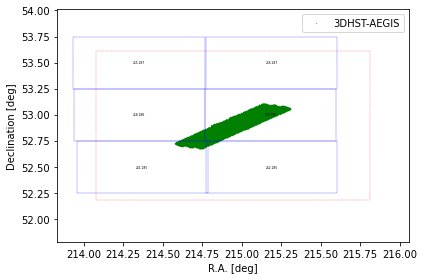

Plotting DEEP2+3...
24 images in overlap area found


<Figure size 432x288 with 0 Axes>

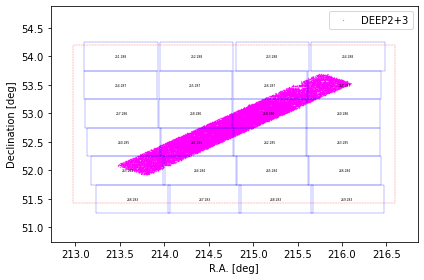

In [18]:
import imp
imp.reload(cfis)
for s in survey:
    
    print('Plotting {}...'.format(s.name))
    
    # Create area string
    area_str = '{0:.2f}{4}_{1:.2f}{4}_{2:.2f}{4}_{3:.2f}{4}'\
               ''.format(s._min_ra - d,
                         s._min_dec - d,
                         s._max_ra + d,
                         s._max_dec + d,
                         unit)
    
    # Get area coordinates from string
    angles = cfis.get_Angle_arr(area_str, num=4)
    
    # Get images in selected area
    images_overlap = cfis.find_images_in_area(images, angles, band, image_type)
    print('{} images in overlap area found'.format(len(images_overlap)))

    fig, (ax) = plt.subplots()
    #plt.tight_layout()

    # Plot spectroscopic objects
    ax.plot(s._ra, s._dec, '.', color=s.color, markersize=0.5, label=s.name)

    # Plot images
    cfis.plot_area(images_overlap, angles, image_type, None, False,
                   show_circle=False, ax=ax, save=False)

    plt.xlabel('R.A. [{}]'.format(unit))
    plt.ylabel('Declination [{}]'.format(unit))
    plt.legend(loc='best')
    plt.show()
    plt.savefig('{}.pdf'.format(s.name))